# CLEAN BUILD FROM SCRATCH EFFNET-UNET b7 on patches

In [1]:
CURRENT_FOLD = 3

# imports

In [2]:
import random

import numpy as np
import pandas as pd
import cv2 as cv
import os

from matplotlib import pyplot as plt
from glob import glob
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from IPython.display import clear_output

import albumentations as A
import albumentations.pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.cuda.amp as amp
is_amp = True

# data

In [3]:
ORGAN2ID = {
    'kidney' : 0,
    'prostate' : 1,
    'largeintestine' : 2,
    'spleen' : 3,
    'lung' : 4
}
ID2ORGAN = {v: k for k, v in ORGAN2ID.items()}

## data 512

In [4]:
# img256 = cv.imread('./../data/train_data_eunet_patches/256/train/10044_0000.png')
# img512 = cv.imread('./../data/train_data_eunet_patches/512/train/10044_0000.png')

In [5]:
TRAIN_CSV = './../data/train.csv'
TEST_CSV = './../data/test.csv'
TRAIN_IMAGES_DIR = './../data/train_data_eunet_patches/512/train/'
TRAIN_MASKS_DIR = './../data/train_data_eunet_patches/512/masks/'

N_CROSS_VALID_SPLITS = 5
RANDOM_SEED = 2022

SPATIAL_SIZE = 512 # размер патча


In [6]:
train_df = pd.read_csv(TRAIN_CSV)

In [7]:
def make_train_image_path(row):
    return os.path.join(TRAIN_IMAGES_DIR, str(row['id']) + '.png')

def make_train_mask_path(row):
    return os.path.join(TRAIN_MASKS_DIR, str(row['id']) + '.png')

def create_folds(df: pd.DataFrame, n_splits: int, random_seed: int) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["organ"])):
        df.loc[val_idx, "fold"] = int(fold)

    return df

In [8]:
train_df = create_folds(train_df, n_splits=N_CROSS_VALID_SPLITS, random_seed=RANDOM_SEED)

In [9]:
def make_512_dataset(df):
    new_df = []
    for index, row in df.iterrows():
        id = row['id']
        glb = list(glob(TRAIN_IMAGES_DIR + '{}_*.png'.format(id)))
        for fname in glb:
            newrow = dict()
            newrow['id'] = id
            newrow['image'] = fname
            newrow['mask'] = fname.replace('/train/', '/masks/')
            newrow['organ'] = row['organ']
            newrow['pixel_size'] = row['pixel_size']
            newrow['fold'] = row['fold']
            
            new_df.append(newrow)
    return pd.DataFrame(new_df)

In [10]:
train_df_512 = make_512_dataset(train_df)
print(train_df_512.shape)
train_df_512.head()

(2895, 6)


,fold,id,image,mask,organ,pixel_size
0,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
1,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
2,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
3,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
4,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4


In [11]:
# ---------------------------------------------------------------
# WARNING! THIS RESCALE IS INJECTED IN SWIN TRANSFORMER ALREADY!
#   RGB LAYER
# IT'S INPUTS HAVE TO BE IMAGE IN 0..1!
# ---------------------------------------------------------------

In [12]:
# mean = np.array([0.7720342, 0.74582646, 0.76392896])
# std = np.array([0.24745085, 0.26182273, 0.25782376])

In [13]:
train_transform= A.Compose([
    A.Resize(512, 512, interpolation=cv.INTER_LINEAR),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HueSaturationValue(p=0.25),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=(0.05, 0.6),rotate_limit=90, p=0.5),
    A.ElasticTransform(p=0.1, alpha=90, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.GridDistortion(p=0.25),
    A.Blur(blur_limit=5, p=0.1),
    A.GaussNoise(var_limit=(20, 100), p=0.2),
    A.ChannelDropout(p=0.05),
    A.RandomGamma(p=0.1),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], 
                max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [14]:
val_transform = A.Compose([
#     A.Resize(512, 512, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1],
                 max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [15]:
class HubmapDataset512(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        self.transform = transform
        self.length = len(self.df)

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k,d.get(k,0),d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]
        organ = ORGAN2ID[d['organ']]

        image = cv.cvtColor(cv.imread(d['image']), cv.COLOR_BGR2RGB) # .astype(np.float32) / 255.0
        mask = cv.imread(d['mask'], cv.IMREAD_GRAYSCALE)

        mask = mask / max(1, mask.max())
        
        mask_multiclass = mask * (organ + 1)
        
        data = {
            'image': image,
            'mask': mask_multiclass,
            'organ': organ,
        }
        
        upd_data = self.transform(image=data['image'], mask=data['mask'])

        data.update(upd_data)
        return data

In [16]:
def worker_init_fn(worker_id):
    torch_seed = torch.initial_seed()
    random.seed(torch_seed + worker_id)
    if torch_seed >= 2**30:  # make sure torch_seed + workder_id < 2**32
        torch_seed = torch_seed % 2**30
    np.random.seed(torch_seed + worker_id)
    random.seed(torch_seed + worker_id + 77777)

In [17]:
train_dataset = HubmapDataset512(train_df_512[train_df_512['fold'] != CURRENT_FOLD], train_transform)
val_dataset = HubmapDataset512(train_df_512[train_df_512['fold'] == CURRENT_FOLD], val_transform)

IMAGE
torch.Size([3, 512, 512])
image values:  0.0 0.9647059440612793


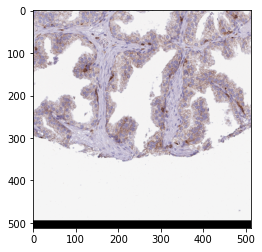

MASK
torch.Size([512, 512])
mask values:  tensor(0., dtype=torch.float64) tensor(2., dtype=torch.float64)


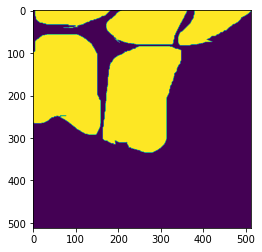

In [18]:
sample = train_dataset[1]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].permute((1, 2, 0)))
plt.show()

print('MASK')
print(sample['mask'].shape)
print('mask values: ', sample['mask'].min(), sample['mask'].max())
plt.imshow(sample['mask'])
plt.show()

In [19]:
BATCH_SIZE = 10

In [20]:
loader_params = {'shuffle': True,
                 'num_workers': 0,
                 'worker_init_fn': worker_init_fn}
loader_train = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          worker_init_fn=worker_init_fn,
                          num_workers=12
                         )
loader_val = DataLoader(val_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        worker_init_fn=worker_init_fn,
                        num_workers=0
                       )

IMAGE
torch.Size([3, 512, 512])
image values:  0.0 1.0


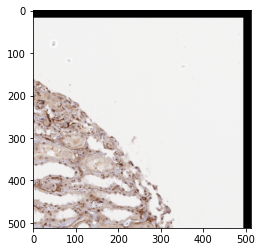

MASK
torch.Size([512, 512])
mask values:  tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)


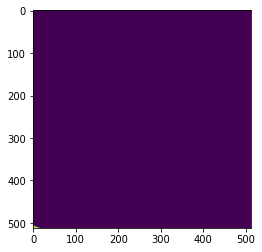

In [21]:
sample = val_dataset[2]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].permute((1, 2, 0)))
plt.show()

print('MASK')
print(sample['mask'].shape)
print('mask values: ', sample['mask'].min(), sample['mask'].max())
plt.imshow(sample['mask'])
plt.show()

# model

In [22]:
device = 'cuda:3'
DEVICE = device

In [23]:
from swintransformer import *

In [24]:
pretrain_dir = './../swin-transformer-first-try'

In [25]:
cfg = dict(
    output_type = ['logits'],
    num_classes = 6,
        #configs/_base_/models/upernet_swin.py
    basic = dict(
        swin=dict(
            embed_dim=96,
            depths=[2, 2, 18, 2],
            num_heads=[3, 6, 12, 24],
            window_size=7,
            mlp_ratio=4.,
            qkv_bias=True,
            qk_scale=None,
            drop_rate=0.,
            attn_drop_rate=0.,
            drop_path_rate=0.3,
            ape=False,
            patch_norm=True,
            out_indices=(0, 1, 2, 3),
            use_checkpoint=False
        ),

    ),

    #configs/swin/upernet_swin_tiny_patch4_window7_512x512_160k_ade20k.py
    swin_tiny_patch4_window7_224=dict(
        checkpoint = pretrain_dir+'/swin_tiny_patch4_window7_224_22k.pth',

        swin = dict(
            embed_dim=96,
            depths=[2, 2, 6, 2],
            num_heads=[3, 6, 12, 24],
            window_size=7,
            ape=False,
            drop_path_rate=0.3,
            patch_norm=True,
            use_checkpoint=False,
        ),
        upernet=dict(
            in_channels=[96, 192, 384, 768],
        ),
    ),

    #/configs/swin/upernet_swin_small_patch4_window7_512x512_160k_ade20k.py
    swin_small_patch4_window7_224_22k=dict(
        checkpoint = pretrain_dir+'/swin_small_patch4_window7_224_22k.pth',

        swin = dict(
            embed_dim=96,
            depths=[2, 2, 18, 2],
            num_heads=[3, 6, 12, 24],
            window_size=7,
            ape=False,
            drop_path_rate=0.3,
            patch_norm=True,
            use_checkpoint=False
        ),
        upernet=dict(
            in_channels=[96, 192, 384, 768],
        ),
    ),
)

In [26]:
model = Net(cfg, arch='swin_small_patch4_window7_224_22k').to(device)

loading Arch swin_small_patch4_window7_224_22k

Params:
{'embed_dim': 96, 'depths': [2, 2, 18, 2], 'num_heads': [3, 6, 12, 24], 'window_size': 7, 'mlp_ratio': 4.0, 'qkv_bias': True, 'qk_scale': None, 'drop_rate': 0.0, 'attn_drop_rate': 0.0, 'drop_path_rate': 0.3, 'ape': False, 'patch_norm': True, 'out_indices': (0, 1, 2, 3), 'use_checkpoint': False, 'out_norm': <class 'swintransformer.LayerNorm2d'>}


/opt/conda/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [27]:
model.load_pretrain()

loading ./../swin-transformer-first-try/swin_small_patch4_window7_224_22k.pth ...
_IncompatibleKeys(missing_keys=['out_norm.0.weight', 'out_norm.0.bias', 'out_norm.1.weight', 'out_norm.1.bias', 'out_norm.2.weight', 'out_norm.2.bias', 'out_norm.3.weight', 'out_norm.3.bias'], unexpected_keys=['norm.weight', 'norm.bias', 'head.weight', 'head.bias', 'layers.0.blocks.1.attn_mask', 'layers.1.blocks.1.attn_mask', 'layers.2.blocks.1.attn_mask', 'layers.2.blocks.3.attn_mask', 'layers.2.blocks.5.attn_mask', 'layers.2.blocks.7.attn_mask', 'layers.2.blocks.9.attn_mask', 'layers.2.blocks.11.attn_mask', 'layers.2.blocks.13.attn_mask', 'layers.2.blocks.15.attn_mask', 'layers.2.blocks.17.attn_mask'])


In [28]:
sample_input = torch.randn(1, 3, 512, 512).to(device)

In [29]:
sample_output = model({'image': sample_input})

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [30]:
for key, v in sample_output.items():
    print('{:10} : {}'.format(key, v.shape))

out_logits : torch.Size([1, 6, 512, 512])
aux0_logits : torch.Size([1, 6, 512, 512])
aux1_logits : torch.Size([1, 6, 512, 512])
aux2_logits : torch.Size([1, 6, 512, 512])
aux3_logits : torch.Size([1, 6, 512, 512])


In [31]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

63627752

# lr schedule

In [96]:
def lr_function(step):
    start_lr = 1e-5; min_lr = 1e-5; max_lr = 5e-4    #A
    rampup_epochs = 1000; sustain_epochs = 200; exp_decay = .99997    #B
 
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs,
           sustain_epochs, exp_decay):
        if epoch < rampup_epochs:    #C
            lr = ((max_lr - start_lr) / rampup_epochs
                        * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:    #D
            lr = max_lr
        else:    #E
            lr = max((max_lr - min_lr) *
                      exp_decay**(epoch - rampup_epochs -
                                    sustain_epochs)* (0.8+0.05*np.sin(epoch / 100)), 0) + min_lr
        return lr
 
    return 0.2 # lr(step, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay) / max_lr

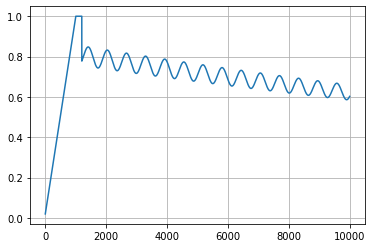

In [62]:
xxx = []
for i in range(10000):
    xxx.append(lr_function(i))
    
plt.plot(xxx)
plt.grid()
plt.show()

# Criterions

In [63]:
import segmentation_models_pytorch as smp

In [64]:
# def criterion_aux_loss(logit, mask):
#     mask = F.interpolate(mask,size=logit.shape[-2:], mode='nearest')
#     print(logit.shape, mask.shape)
#     loss = F.cross_entropy(logit, mask)
#     return loss

In [65]:
ce_loss = nn.CrossEntropyLoss().to(device)

In [66]:
criterion_aux_loss = ce_loss

In [67]:
criterion_tversky_punish_fn = smp.losses.TverskyLoss(
    mode='multiclass', classes=None, log_loss=False, 
    from_logits=True, smooth=1e-6, ignore_index=None, 
    eps=1e-07, alpha=0.3, beta=0.7, gamma=3/4
)

criterion_tversky_punish_fp = smp.losses.TverskyLoss(
    mode='multiclass', classes=None, log_loss=False, 
    from_logits=True, smooth=1e-6, ignore_index=None, 
    eps=1e-07, alpha=0.7, beta=0.3, gamma=3/4
)

In [68]:
criterion_dice = smp.losses.TverskyLoss(
    mode='multiclass', classes=None, log_loss=False, 
    from_logits=True, smooth=0.0, ignore_index=None, 
    eps=1e-07, alpha=0.5, beta=0.5, gamma=1
)

In [69]:
def criterion_image_1(predicts, masks):
    return 0.3 * ce_loss(predicts, masks) + 0.7 * criterion_tversky_punish_fn(predicts, masks)

In [70]:
def criterion_image_2(predicts, masks):
    return 0.3 * ce_loss(predicts, masks) + 0.7 * criterion_tversky_punish_fp(predicts, masks)

In [71]:
def criterion_image_3(predicts, masks):
    return 0.5 * ce_loss(predicts, masks) + 0.5 * criterion_dice(predicts, masks)

In [72]:
def criterion_schedule(epoch):
    if epoch < 40:
        criterion_image = ce_loss
        criterion_aux = criterion_aux_loss
    elif 40 <= epoch <= 70:
        criterion_image = criterion_image_1
        criterion_aux = criterion_aux_loss
    elif 70 <= epoch <= 80:
        criterion_image = criterion_image_2
        criterion_aux = criterion_aux_loss
    else:
        criterion_image = criterion_image_3
        criterion_aux = criterion_aux_loss
        
    return criterion_image, criterion_aux

# validation code

In [89]:
import monai
from monai.utils.enums import BlendMode, PytorchPadMode
from monai.inferers import sliding_window_inference

In [90]:
def dice_coef2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union < 1: 
        return 1
    intersection = np.sum(y_true_f * y_pred_f)
#     print('UNION', union)
    return 2. * intersection / union

In [91]:
class Predictor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        out = self.model({'image' : x})
        prob = F.softmax(out['out_logits'], dim=1)
        return prob

In [76]:
def infer_id(predictor, id: str, organ: str, pixel_size=0.4):
    THRESHOLD = 0.5
    
    image = cv.imread('./../data/train_images/{}.tiff'.format(id))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    gt_mask  = np.load('./../data/train_masks/{}.npy'.format(id))
    
    scale_factor = 0.5 * (pixel_size / 0.4)
    image = cv.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv.INTER_AREA)
    
#     image_rot = image.copy()
    masks = []
    for _ in range(1):
#         image_rot = cv.rotate(image, cv.ROTATE_90_CLOCKWISE)
        
        image_tensor = val_transform(image=image)['image']

        image_tensor = image_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            infer_result = sliding_window_inference(
                image_tensor, roi_size=(512, 512), sw_batch_size=2, predictor=predictor, 
                overlap=0.25, mode=BlendMode.CONSTANT, sigma_scale=0.125, 
                padding_mode=PytorchPadMode.CONSTANT, cval=0.0,       
            )

        organ_id = ORGAN2ID[organ] + 1
        pr_mask = infer_result.detach().cpu().numpy()[0, organ_id]
        masks.append(pr_mask)
        
    pr_mask = (np.array(masks).mean(axis=0) > THRESHOLD).astype(np.uint8)
#     print(gt_mask.shape, gt_mask.dtype, pr_mask.dtype)
    pr_mask = cv.resize(pr_mask, gt_mask.shape, cv.INTER_NEAREST)
    
    return pr_mask, gt_mask

In [77]:
def validate(val_df, model):
    predictor = Predictor(model)
    
    dices = []
    
    by_organ_dice = {key:[] for key in ORGAN2ID.keys()}
    for index, row in tqdm(val_df.iterrows(), total=len(val_df)):
        id = row['id']
        organ = row['organ']
        pixel_size = row['pixel_size']
        pred_mask, gt_mask = infer_id(predictor, id, organ=organ, pixel_size=pixel_size)
        dice = dice_coef2(gt_mask, pred_mask)
        dices.append(dice)
        by_organ_dice[organ].append(dice)
    new_record = dict()
    new_record['dices'] = dices
    new_record['by_organ'] = by_organ_dice
    return new_record

# training

In [97]:
val_df_id = train_df[train_df['fold'] == CURRENT_FOLD]

In [98]:
learning_rate = 5e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.0005)

In [99]:
scaler = amp.GradScaler(enabled = is_amp)

In [100]:
scheduler_warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_function)

In [82]:
train_loss = []
accuracy = [] 
lr_hist = []

In [83]:
logfile = open('log.train.txt', mode='a')
logfile.write('\n--- [START %s] %s\n\n' % ('Effnet-unet-b7', '-' * 64))

94

In [84]:
def log(string):
    print(string)
    logfile.write(string + '\n')

In [85]:
# !mkdir checkpoint_fold_3

In [86]:
N_EPOCHS = 400
global_it = 0
VIRTUAL_BATCH_SIZE = 2

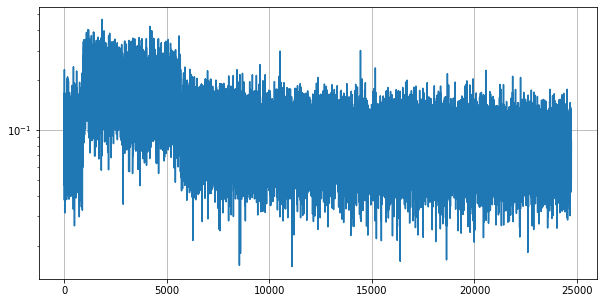

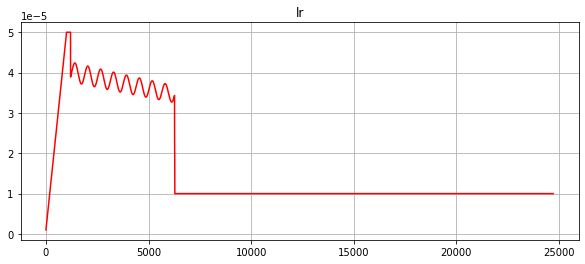

==> Epoch 246 (162/231) | loss: 0.12060
==> Epoch 246 (172/231) | loss: 0.03472
==> Epoch 246 (182/231) | loss: 0.09261
==> Epoch 246 (192/231) | loss: 0.08176
==> Epoch 246 (202/231) | loss: 0.03036
==> Epoch 246 (212/231) | loss: 0.08462
==> Epoch 246 (222/231) | loss: 0.14155
Eval


 16%|█▌        | 11/70 [00:07<00:38,  1.53it/s]


KeyboardInterrupt: 

In [101]:
for epoch in range(86, N_EPOCHS):
    criterion_image, criterion_aux = criterion_schedule(epoch)
    
    model.train()
    
    batch_train_loss = []
    
    for iteration, batch in enumerate(loader_train):
        global_it += 1
        
        batch['image'] = batch['image'].half().to(device)
        batch['mask' ] = batch['mask' ].to(device, dtype=torch.long)
#         batch['organ'] = batch['organ'].cuda()

        with amp.autocast(enabled = is_amp):
            output = model(batch)
            
            loss0      = criterion_image(output['out_logits'],   batch['mask'])
            loss_aux2  = criterion_aux  (output['aux2_logits'],  batch['mask']).mean()
            loss_aux3  = criterion_aux  (output['aux3_logits'],  batch['mask']).mean()
            

        optimizer.zero_grad()
        loss = loss0 + 0.3 * loss_aux3 + 0.2 * loss_aux2
        
        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()

        
        # ---
                 
        batch_train_loss.append(loss.item())          
        
        if global_it % VIRTUAL_BATCH_SIZE == 0:
            train_loss.append(np.mean(batch_train_loss))
            batch_train_loss = []
            lr_hist.append(optimizer.param_groups[0]['lr'])
            scheduler_warmup.step()
                    
        if global_it % (VIRTUAL_BATCH_SIZE * 5) == 0:
            log('==> Epoch {} ({:03d}/{:03d}) | loss: {:.5f}'.format(epoch + 1, iteration, len(loader_train), loss.item()))

        
            
        if iteration % (VIRTUAL_BATCH_SIZE * 40) == 0:
            clear_output()

            plt.figure(figsize=(10, 5))
            plt.yscale('log')
            plt.plot(train_loss)
            plt.grid()
            plt.show()
              
            plt.figure(figsize=(10, 4))
            plt.plot(lr_hist, color='red')
            plt.title('lr')
            plt.grid()
            plt.show()
        
    # val -------------------------------
    if epoch % 5 == 0:
        log('Eval')
        model.eval()

        with torch.no_grad():
            val_res = validate(val_df_id, model)
            val_dice = np.mean(val_res['dices'])
            log('DICE: {}'.format(val_dice))
            for key, value in val_res['by_organ'].items():
                log('{:20}: {:6.5f}'.format(key, np.mean(value)))

            torch.save(model.state_dict(), os.path.join(
                './checkpoint_fold_{}'.format(CURRENT_FOLD), 
                'swinv1_small_ep_{:03d}_dice_{:08.6f}.pt'.format(epoch, val_dice)
            )) 
            logfile.flush()